1/1 [==============================] - 0s 228ms/step


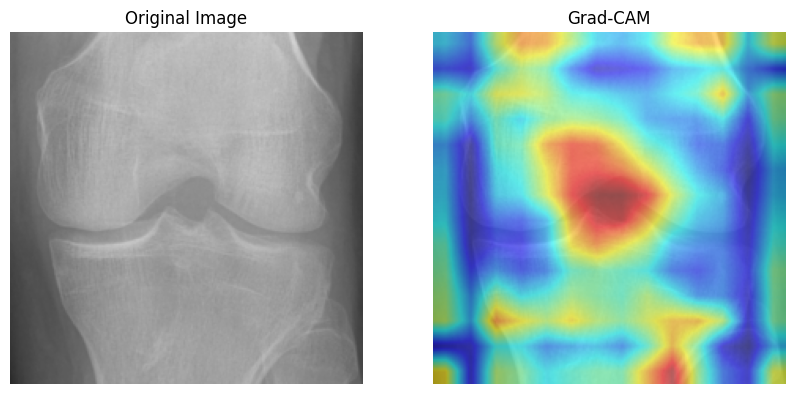

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import cv2

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def get_grad_cam(model, img_array, layer_name, class_index):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)
    cam = np.maximum(cam, 0)

    cam = cv2.resize(cam, (img_array.shape[2], img_array.shape[1]))  
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    return cam

def overlay_grad_cam(img_path, cam):
    img = cv2.imread(img_path)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + img / 255
    overlay = overlay / np.max(overlay)
    overlay = (overlay * 255).astype(np.uint8)  
    return overlay


model = VGG16(weights='imagenet')

img_path = r"S:\Adacamic Projects\data\external Injury\external\train\test-2\9094783L.png"
img_array = preprocess_image(img_path)

predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])

layer_name = 'block5_conv3'  
cam = get_grad_cam(model, img_array, layer_name, predicted_class_index)

overlay = overlay_grad_cam(img_path, cam)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.load_img(img_path))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title('Grad-CAM')
plt.axis('off')

plt.show()
